In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%load_ext autoreload
%autoreload 2

from define_inclusion_criteria_utils import (
    make_good_bad_runs,
    parse_mri_notes_to_exclusions,
)

from dd_kable_analysis.config_loader import load_config
from dd_kable_analysis.data_io import (
    load_tsv_data,
    resolve_file,
)

## Overview of basic data details for subjects/runs in `inclusion_subjects_120426.csv`

The `inclusion_subjects_120426.csv` file is a spreadsheet that includes notes that explain when exclusion should occur.  The purpose of this code is to generate a list of subject ids, sess and run numbers for the data that we should begin analysis on.

Note, we are only using session 1 (scan1) data!

### Structure of this notebook
* **Generating Inclusion/Exclusion Files**:  Does not exactly follow what is dictated in `inclusion_subjects_120426.csv` because we discovered a few discrepancies.  Still, we begin with `scan1` data from the subjects listed in the `.csv` and then the behavioral exclusions are redetermined here and then the MRI-based exclusions are inferred from the `inclusion_subjects_120426.csv`.  Briefly, the behavioral exclusion criteria are:
    * **Omit a run that has >10% missingness,  <10% or >90% choseAccept and/or no data in csv.  Omit a subject if they have fewer than 2 "good" runs.**
* **Exploratory code**: This is code I was originally writing to gain understanding of the behavioral exclusions described in `inclusion_subjects_120426.csv` and the figures helped Josh and I realize we wanted slightly different exclusion criteria.  I'm leaving this code for now, so we can recall in the future why we aren't using the other files that Josh created. 


### We end up with: 125 subjects
The breakdown of how many runs each subject has is in the following table:

| Number of runs | Number of subjects |
|----------------|-----------------|
| 2              | 6               |
| 3              | 17              |
| 4              | 102             |

## Generating Inclusion/Exclusion Files

In [2]:
cfg = load_config()

In [3]:
inclusion_file = cfg.subject_lists / 'inclusion_subjects_120426.csv'
inclusion_subjects = pd.read_csv(
    inclusion_file,
    encoding='latin1',
    engine='python',
)

# rename to remove 'sub-'
inclusion_subjects['sub_id'] = inclusion_subjects['participant_id'].str.replace(
    'sub-', '', regex=False
)

### Noticed some subjects are missing the fmriprepped data
We may add these data back in later.  Joe is running fmriprep, but the question is whether we just use his data for these subjects or if we should do something else to figure out why these subjects failed and fix it within our own fmriprep pipeline.  I don't know enough about fmriprep to do this.

The code below will filter out these subjects in the final lists.

In [4]:
bold_files = []
for subid in inclusion_subjects['sub_id']:
    for run in ['1', '2', '3', '4']:
        try:
            bold_file = resolve_file(cfg, subid, 'scan1', run, 'bold')
            bold_files.append(bold_file)
        except:
            print(f'Subject {subid}, run {run} missing')

Subject dmp0005, run 1 missing
Subject dmp0005, run 2 missing
Subject dmp0005, run 3 missing
Subject dmp0005, run 4 missing
Subject dmp0200, run 1 missing
Subject dmp0200, run 2 missing
Subject dmp0200, run 3 missing
Subject dmp0200, run 4 missing
Subject dmp0678, run 3 missing
Subject dmp0678, run 4 missing
Subject dmp0760, run 4 missing
Subject dmp1000, run 3 missing
Subject dmp1000, run 4 missing
Subject dmp1135, run 3 missing
Subject dmp1135, run 4 missing
Subject dmp1231, run 3 missing
Subject dmp1231, run 4 missing


### Make MRI QA exclusion data machine readable
I wrote a function to pull out the MRI exclusions from the spreadsheet.  The text wasn't fully machine readable, so this is just parsing it.

This example is to illustrate that it works properly.  It is used later in the function that makes the good/bad run lists.

In [5]:
# I verified that this function captures everything from the spreadsheet
mri_qa_exclusions = parse_mri_notes_to_exclusions(inclusion_subjects)
print(mri_qa_exclusions)

    sub_id  run                reason
0  dmp0259    1    dvars_nstd outlier
1  dmp0442    1       fd_mean outlier
2  dmp0523    2  Severe Motion (>0.5)
3  dmp0912    3    dvars_nstd outlier
4  dmp1064    1       fd_mean outlier
5  dmp1083    3       fd_mean outlier
6  dmp1165    1         gsr_y outlier
7  dmp1165    2         gsr_y outlier
8  dmp1165    3         gsr_y outlier
9  dmp1165    4         gsr_y outlier


### Assemble bold files in a data frame 
With sub_id, session, run, path columns

#### Evaluating behavioral exclusions
**Omit a run that has >10% missingness,  <10% or >90% choseAccept and/or no data in csv, was flagged in MRI QC.  Omit a subject if they have fewer than 2 "good" runs.**

If a specific analysis requires 3 runs, I can exclude further at that point in time.

In [6]:
good_data, bad_data = make_good_bad_runs(cfg, inclusion_subjects)

In [7]:
print(
    f'Assuming all subjects in inclusion_subjects have 4 runs we would have this many runs: {inclusion_subjects.shape[0] * 4}'
)
print(f'The number of runs that are good: {good_data.shape[0]}')
print(f'The number or runs that were omitted: {bad_data.shape[0]}')

Assuming all subjects in inclusion_subjects have 4 runs we would have this many runs: 520
The number of runs that are good: 454
The number or runs that were omitted: 66


In [8]:
# number of subjects
sub_unique, n_per_sub = np.unique(good_data['sub_id'], return_counts=True)
print(f'There are {len(sub_unique)} subjects')

num_runs, subs_with_num_runs = np.unique(n_per_sub, return_counts=True)
print('Number of runs → Number of subjects with that run count')
for runs, n_subs in zip(num_runs, subs_with_num_runs):
    print(f'{runs:>14} → {n_subs}')

There are 123 subjects
Number of runs → Number of subjects with that run count
             2 → 10
             3 → 18
             4 → 95


In [9]:
# As an extra check I verified this with the figures below
u, c = np.unique(
    bad_data.loc[~bad_data['no_fmriprep_bold']]['sub_id'], return_counts=True
)
out = np.column_stack([u, c])
print(out)

[['dmp0060' 1]
 ['dmp0148' 2]
 ['dmp0154' 1]
 ['dmp0219' 1]
 ['dmp0224' 4]
 ['dmp0229' 1]
 ['dmp0259' 4]
 ['dmp0330' 1]
 ['dmp0357' 1]
 ['dmp0442' 1]
 ['dmp0492' 2]
 ['dmp0502' 1]
 ['dmp0521' 2]
 ['dmp0523' 1]
 ['dmp0587' 2]
 ['dmp0808' 1]
 ['dmp0848' 1]
 ['dmp0912' 1]
 ['dmp0954' 1]
 ['dmp0982' 1]
 ['dmp1037' 2]
 ['dmp1039' 4]
 ['dmp1062' 1]
 ['dmp1064' 2]
 ['dmp1083' 1]
 ['dmp1165' 4]
 ['dmp1172' 4]
 ['dmp1266' 1]]


### Save files





In [10]:
good_file = cfg.subject_lists / 'initial_qa_pass_subjects_runs.csv'
bad_file = cfg.subject_lists / 'initial_qa_fail_subjects_runs_reasons.csv'


# They are already saved, so I don't need to save again if I run the notebook again
# good_data.to_csv(good_file, index=False)
# bad_data.to_csv(bad_file, index=False)

# Exploratory Code (Ignore, keeping just in case)

## Double checking run exclusions
Josh has generated `inclusion_subjects_12046.csv` and I'm translating the noted run exclusions into a machine readable csv.  Note, Josh should review this file after I make it.

Here I manually go through each one that had a comment and check.

While doing this we discovered the csv wasn't necessarily consistent with the criteria we wanted to use so we decided to redo the behavioral omissions using the criteria in the above code.  I'm retaining this code since the figures illustrate the exclusions, which could be a useful reminder in the future.

In [11]:
# note from spreadsheet: Behavior: Run 1 >.2 missed trials
sub_check = 'dmp0219'

behav_file = resolve_file(cfg, sub_check, 'scan1', '1', 'behav')
behav_data = load_tsv_data(behav_file)
print('Percent Missing')
behav_data['RT'].isna().mean()

Percent Missing


np.float64(0.4666666666666667)

### This one may have been mislabeled.  I will check NAs over runs later and will verify with Josh.

Josh said, "that's weird; if it's the only odd duck, I'm guessing it's a transposition error that I made when I created the google sheet"

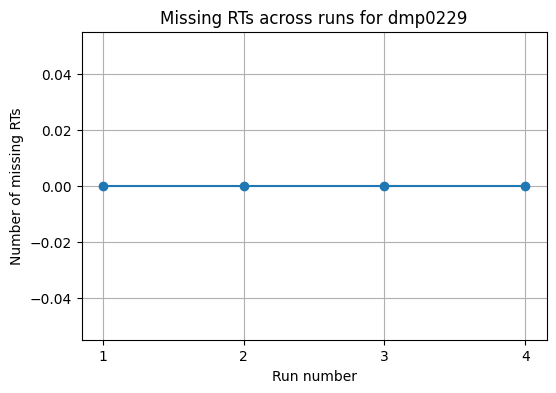

In [12]:
# Behavior: increasing # of nonresponses across session suggests subject falling asleep or disengaged
# See note above, this subject doesn't actually have any exclusions

sub_check = 'dmp0229'
runs = [1, 2, 3, 4]
missing_counts = []

for run in runs:
    # load the behavioral data for this run
    behav_file = resolve_file(cfg, sub_check, 'scan1', str(run), 'behav')
    behav_data = load_tsv_data(behav_file)

    # count missing RTs
    n_missing = behav_data['RT'].isna().sum()
    missing_counts.append(n_missing)

# Create a DataFrame for easy plotting (optional)
missing_df = pd.DataFrame({'run': runs, 'n_missing': missing_counts})

plt.figure(figsize=(6, 4))
plt.plot(missing_df['run'], missing_df['n_missing'], marker='o', linestyle='-')
plt.xticks(runs)
plt.xlabel('Run number')
plt.ylabel('Number of missing RTs')
plt.title(f'Missing RTs across runs for {sub_check}')
plt.grid(True)
plt.show()

### Checking missing data across runs for all subjects to see if the above exclusion comment was possible intended for somebody else.

In [13]:
all_subjects = inclusion_subjects['sub_id'].unique()
runs = [1, 2, 3, 4]

records = []

for sub in all_subjects:
    for run in runs:
        behav_file = resolve_file(cfg, sub, 'scan1', str(run), 'behav')
        behav_data = load_tsv_data(behav_file)
        if len(behav_data) == 0:
            percent_missing = np.nan
        else:
            percent_missing = behav_data['RT'].isna().mean()

        records.append(
            {'sub_id': sub, 'run_num': run, 'percent_missing_rt': percent_missing}
        )

missing_rt_df = pd.DataFrame(records)


In [14]:
# Flag runs that are bad
missing_rt_df['is_weird'] = (missing_rt_df['percent_missing_rt'] > 0.1) | (
    missing_rt_df['percent_missing_rt'].isna()
)

# Subjects with ANY bad run
weird_subjects = missing_rt_df.loc[missing_rt_df['is_weird'], 'sub_id'].unique()

print('Weird subjects:', weird_subjects)

# Pull all runs for those subjects (for plotting / inspection)
weird_df = missing_rt_df[missing_rt_df['sub_id'].isin(weird_subjects)]


Weird subjects: ['dmp0154' 'dmp0219' 'dmp0259' 'dmp0330' 'dmp0492' 'dmp0848' 'dmp1039'
 'dmp1165']


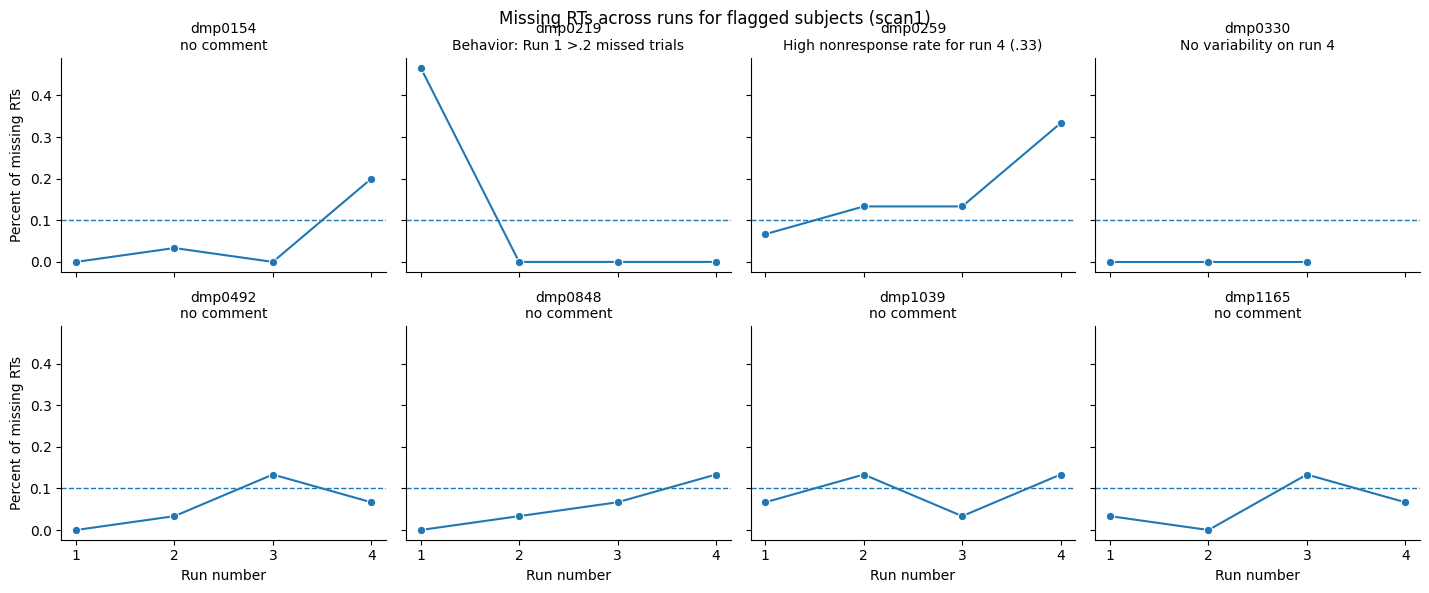

In [15]:
weird_df_plot = weird_df.copy()

inclusion_map = dict(
    zip(
        inclusion_subjects['participant_id'].str.replace('sub-', ''),
        inclusion_subjects['Behavior Notes'].fillna('no comment'),  # fill missing notes
    )
)

# Add a column for behavior note for each row
weird_df_plot['behavior_note'] = weird_df_plot['sub_id'].map(inclusion_map)

weird_df_plot['facet_title'] = (
    weird_df_plot['sub_id'] + '\n' + weird_df_plot['behavior_note']
)
g = sns.relplot(
    data=weird_df_plot,
    x='run_num',
    y='percent_missing_rt',
    col='facet_title',  # use combined title
    kind='line',
    marker='o',
    col_wrap=4,  # wrap after 4 panels
    height=3,
    aspect=1.2,
)
for ax in g.axes.flatten():
    ax.axhline(0.1, linestyle='--', linewidth=1)

g.set_axis_labels('Run number', 'Percent of missing RTs')
g.set_titles('{col_name}')  # now uses the facet_title
g.set(xticks=[1, 2, 3, 4])
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Missing RTs across runs for flagged subjects (scan1)')

plt.show()

## Subject dmp0229 seems okay and they were not flagged here.  Perhaps I'm not understanding the issue with the behavioral data.

Over email, we decided to exclude runs with >10% missing data, excluding a subject only when they have fewer than 2 good runs.  This means I will likely need to redo the exclusions since there are subjects in the above figure who have bad runs, but they didn't have any comments in the `inclusion_subjects_120426.csv`

The above figure verifies subject 0259's issue:
"High nonresponse rate for run 4 (.33)"


### To check 0330 and other subjects, collect percent "choseAccept" for each subject/run

I think I misunderstood the comment for 0330 of "low variability", I think their events file is simply empty.  See secondary check after this.

In [16]:
all_subjects = inclusion_subjects['sub_id'].unique()
runs = [1, 2, 3, 4]

records = []

for sub in all_subjects:
    for run in runs:
        behav_file = resolve_file(cfg, sub, 'scan1', str(run), 'behav')
        behav_data = load_tsv_data(behav_file)

        non_missing = behav_data['choseAccept'].dropna()
        if non_missing.empty:
            percent_accept = float('nan')
        else:
            percent_accept = non_missing.mean() * 100

        records.append(
            {'sub_id': sub, 'run_num': run, 'percent_accept': percent_accept}
        )

chose_accept_df = pd.DataFrame(records)

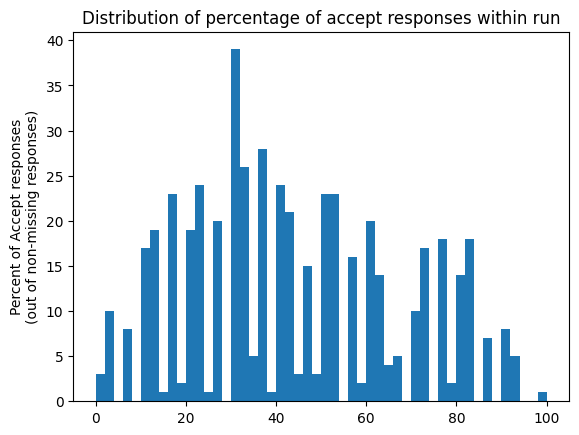

In [17]:
plt.hist(chose_accept_df['percent_accept'], 50)
plt.title('Distribution of percentage of accept responses within run')
plt.ylabel('Percent of Accept responses\n(out of non-missing responses)')
plt.show()

In [18]:
# Previously, only these subjects were omitted.
print(chose_accept_df.loc[chose_accept_df['percent_accept'] == 0])

print(chose_accept_df.loc[chose_accept_df['percent_accept'] == 100])

      sub_id  run_num  percent_accept
203  dmp0521        4             0.0
230  dmp0587        3             0.0
511  dmp1266        4             0.0
      sub_id  run_num  percent_accept
466  dmp1172        3           100.0


In [19]:
weird_subjects_accept = (
    chose_accept_df.groupby('sub_id')['percent_accept']
    .apply(lambda x: (x < 10).any() or (x > 90).any())
    .reset_index()
)

# Filter to only the True rows
weird_subjects_accept = weird_subjects_accept[weird_subjects_accept['percent_accept']][
    'sub_id'
].tolist()

In [20]:
weird_df_accept = chose_accept_df[
    chose_accept_df['sub_id'].isin(weird_subjects_accept)
].copy()


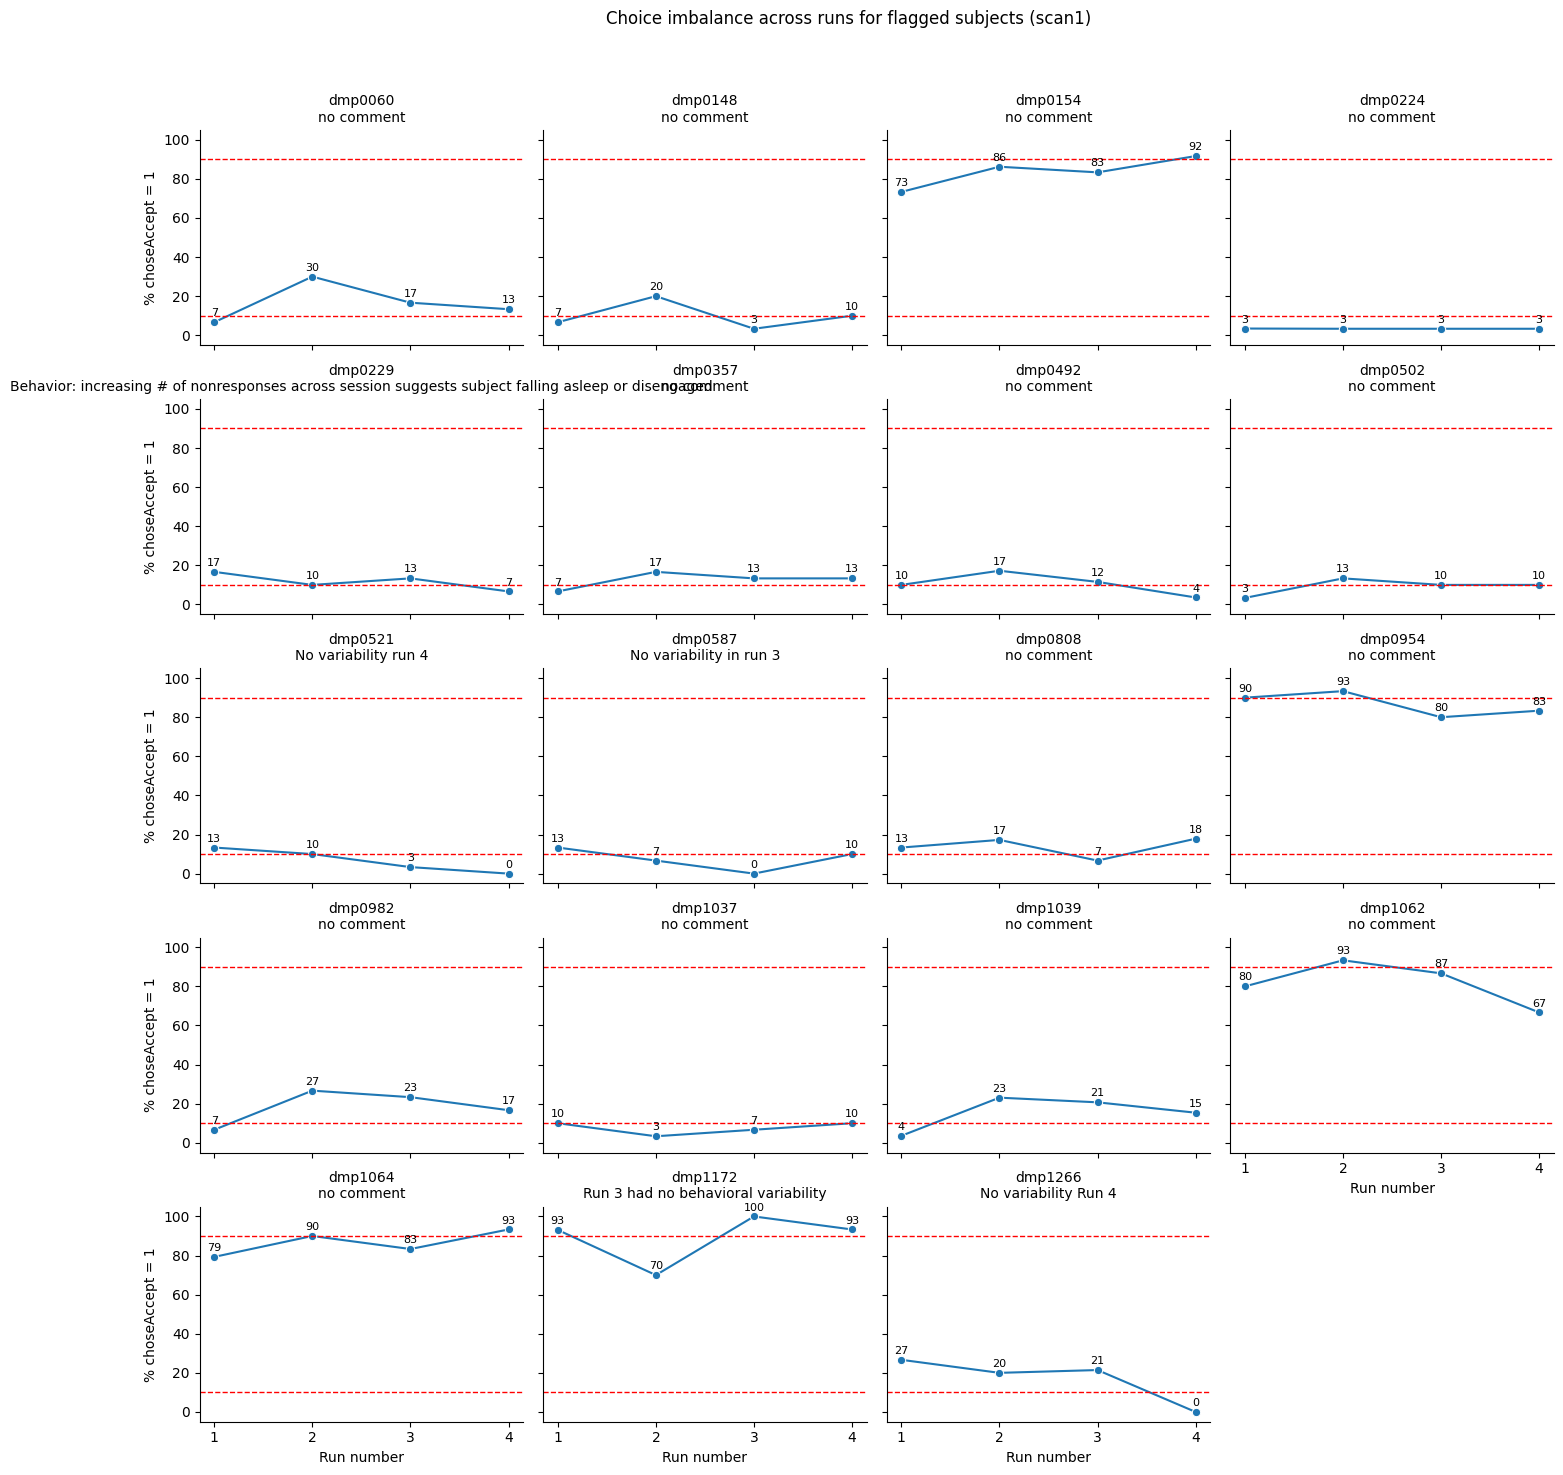

In [21]:
inclusion_map = dict(
    zip(
        inclusion_subjects['participant_id'].str.replace('sub-', ''),
        inclusion_subjects['Behavior Notes'].fillna('no comment'),
    )
)

weird_df_accept['behavior_note'] = weird_df_accept['sub_id'].map(inclusion_map)

# Combine for facet titles
weird_df_accept['facet_title'] = (
    weird_df_accept['sub_id'] + '\n' + weird_df_accept['behavior_note']
)


g = sns.relplot(
    data=weird_df_accept,
    x='run_num',
    y='percent_accept',
    col='facet_title',
    kind='line',
    marker='o',
    col_wrap=4,  # wrap panels
    height=3,
    aspect=1.2,
)

g.set_axis_labels('Run number', '% choseAccept = 1')
g.set_titles('{col_name}')
g.set(xticks=[1, 2, 3, 4])
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Choice imbalance across runs for flagged subjects (scan1)')

for ax in g.axes.flatten():
    ax.axhline(10, color='red', linestyle='--', linewidth=1)
    ax.axhline(90, color='red', linestyle='--', linewidth=1)
for ax, facet in zip(g.axes.flatten(), g.col_names):
    facet_data = weird_df_accept[weird_df_accept['facet_title'] == facet]

    for _, row in facet_data.iterrows():
        ax.text(
            row['run_num'],
            row['percent_accept'] + 2,  # vertical offset
            f'{row["percent_accept"]:.0f}',
            ha='center',
            va='bottom',
            fontsize=8,
        )
plt.show()

### Check if behavioral file doesn't contain any data

In [22]:
all_subjects = inclusion_subjects['sub_id'].unique()
runs = [1, 2, 3, 4]

records = []

for sub in all_subjects:
    for run in runs:
        behav_file = resolve_file(cfg, sub, 'scan1', str(run), 'behav')
        behav_data = load_tsv_data(behav_file)
        num_lines = behav_data.shape[0]

        records.append({'sub_id': sub, 'run_num': run, 'num_lines_data': num_lines})

num_lines_data_df = pd.DataFrame(records)

In [23]:
np.unique(num_lines_data_df['num_lines_data'], return_counts=True)

(array([ 0, 30, 37, 38]), array([  1, 515,   2,   2]))

### Verifies run 4 for subject 0330 should be excluded

In [24]:
num_lines_data_df.loc[num_lines_data_df['num_lines_data'] == 0,]

,sub_id,run_num,num_lines_data
147,dmp0330,4,0


### The above figure of percent choseAccept captured these subjects who were flagged in Josh's file

In [25]:
chose_accept_df.loc[chose_accept_df['sub_id'] == 'dmp0521']

,sub_id,run_num,percent_accept
200,dmp0521,1,13.333333
201,dmp0521,2,10.000000
202,dmp0521,3,3.333333
203,dmp0521,4,0.000000


In [26]:
chose_accept_df.loc[chose_accept_df['sub_id'] == 'dmp0587']

,sub_id,run_num,percent_accept
228,dmp0587,1,13.333333
229,dmp0587,2,6.666667
230,dmp0587,3,0.000000
231,dmp0587,4,10.000000


In [27]:
chose_accept_df.loc[chose_accept_df['sub_id'] == 'dmp1172']

,sub_id,run_num,percent_accept
464,dmp1172,1,93.103448
465,dmp1172,2,70.000000
466,dmp1172,3,100.000000
467,dmp1172,4,93.333333


In [28]:
chose_accept_df.loc[chose_accept_df['sub_id'] == 'dmp1266']

,sub_id,run_num,percent_accept
508,dmp1266,1,26.666667
509,dmp1266,2,20.000000
510,dmp1266,3,21.428571
511,dmp1266,4,0.000000


### Complete except for subject 0229

## STOPPING HERE
At this point we relized we weren't going to be able to use exclude_data, but it would be easier to redefine the exclusion criteria, which is what the first section of this notebook does.